#  Stacking for the estimation of Treatment Effects

##The inherent difficulty of estimating treatment effects
In estimating the effect of a treatment, we would ideally like to know what the outcome $y_i$ would have been, had the treated not received treatment, and had the treated been left untreated.
This is almost always impossible, firstly because of the likely impossibility of time travel. Indeed, we will never be able to set up an experiment where each person in the treatment group has their exact twin in the control group.
But another reason, specifically in marketing, is that a treatment (like a voucher for some online market) may be very expensive to offer to all or even one half of the sample.

In an experimental setup, or a situation in which we have treated and untreated data, it is necessary to estimate the underlying distribution of the 'nuisance variables' $X_i$ as well as the propensity score (the likelihood, given an observation's characteristics, to be treated) $e_i$, in order to be able to extract the effect of the treatment.
^^^maybe talk specifically here about propensity score. or give a really simple example of why its hard to estimate a treatment effect with a skewed treatment group.
^^^i think grimmer has a good quote

# 1. Synthesizing data
For the reasons above, we will synthesize data on which we will carry out stacking experiments, in order to compare the predictive results of our models depending on the shape of the underlying data, and conclude upon the effectiveness of stacking for treatment effects in each situation.
We generate data according to the same process as *Nie X. and Wager S. (2018) 'Quasi-Oracle Estimation of Heterogeneous Treatment Effects'*. a library for generating different kinds of data specifically for the study of treatment effects is provided by `causalml` from uber (https://github.com/uber/causalml).

`causalml` provides an implementation of each data generating function as seen in Nie & Wager, accessible through five possible modes passed to synthetic_data() :

Each of these provides a data set of $X_i$ variables, propensity to be treated $e_i$ as a function of the $X_i$ (or as a random function, in some cases), and a treatment effect as a function of the $X_i$.
Generated datasets also have the advantage that we may generate as much data as we need in order to cross validate and otherwise test, with the guarantee that all the data generated comes from the same distribution. The `causalml` datasets also provide us with the true treatment effect and true outcome without treatment, so that we may be able to test the predicted $y_i$ and $\tau(X_i)$

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
[MLENS] backend: threading


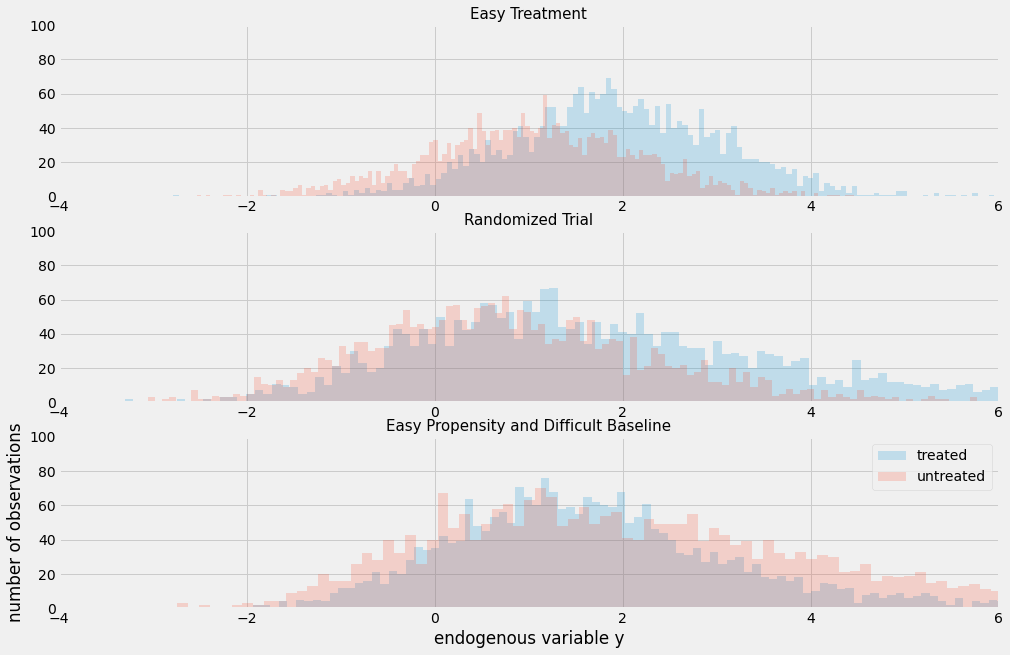

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from causalml.dataset import *
from causalml.inference.meta import BaseRRegressor
from mlens.ensemble import SuperLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import data_gen
import simple_model
import stacking_helpers

y_easy, X_easy, w_easy, tau_easy, b_easy, e_easy = simulate_nuisance_and_easy_treatment(n=5000, p=5)
y_rand, X_rand, w_rand, tau_rand, b_rand, e_rand = simulate_randomized_trial(n=5000, p=5)
y_difficult, X_difficult, w_difficult, tau_difficult, b_difficult, e_difficult = simulate_easy_propensity_difficult_baseline(
    n=5000, p=5)

plt.figure(figsize=(15,10))
data_gen.treated_vs_untreated_plot(y_easy, w_easy, 'Easy Treatment', 311)
data_gen.treated_vs_untreated_plot(y_rand, w_rand, 'Randomized Trial', 312)
data_gen.treated_vs_untreated_plot(y_difficult, w_difficult, 'Easy Propensity and Difficult Baseline', 313)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
_ = plt.legend()
plt.show()

Above we plot the distribution of the outcome variable $y$, and how it differs between the treated and the control groups.
In the 'Setup A' of Nie and Wager - reproducing an easy to estimate treatment effect (from causalml: `y = b + (w - 0.5) * tau + sigma * np.random.normal(size=n)`) we can see that the distribution of the treatment arm is just shifted to the right of the control.
In other setups, however, the difference in the outcome is unclear -- in the 'Easy Propensity and Difficult Baseline' setup, there is no clear treatment effect just examining the distribution of Y. (y = b + (w - 0.5) * tau + sigma * np.random.normal(size=n))
where `e = 1/(1 + np.exp(X[:, 1] + X[:, 2]))`
So we should like to see how different approaches to estimating the underlying X's and the different methods used ot stack them compare over different sets.

# 2. The 'S-Learner' - Simulations
Grimmer, Messing, Westwood (2017) find that the ensemble method is better than any single model in all cases, soemtimes much much better.. Used on political data with many categorical variables. (real-life data).
Nie and Wager estimate treatment effects using (among other heterogeneous treatment effect estimators) the 'S-Learner'. `causalml library also provides an S-learner as used in Grimmer (2017).

where the treatment effect is estimated by simple comparison of the treated against the untreated, with the same underlying $X_i$. This involves training a machine learning model, the

The S Learner fits the functions $ \mu^*_w(x) = E(Y\mid X = x, W = w)$ separately for the treatment and the control groups (for $w \in{0, 1}$), and then estimates $\tau(x) = \mu_1(x) - \mu_0(x)$
The S learner (`BaseTRegressor()`) as implemented by `causalml` can be fed a machine learning model to estimate and predict the outcome $y_i$ in both cases, in order to compute a conditional treatment effect.

the difference between doing this and using the T learner, which learns each arm independently, is that the S learner can account for the covariance between assignment $w_i$ and the nuisance variables $X_i$.


ANOTHER THING WE NEED TO DO : explain the train_test_split and some idea behind. -- _this is in the helper functions and could go in the markdown_

In [2]:
regressors = { 'regressor_lr' :LinearRegression(),
               'regressor_nn': MLPRegressor(),
               'regressor_dt' : DecisionTreeRegressor(),
               'regressor_xgb' : XGBRegressor(),
               'regressor_rf': RandomForestRegressor()}

In [3]:
easy_preds, tau_easy_test = simple_model.compare_single_models(X_easy, y_easy, w_easy, tau_easy, regressors)
rand_preds, tau_rand_test = simple_model.compare_single_models(X_rand, y_rand, w_rand, tau_rand, regressors)
difficult_preds, tau_difficult_test = simple_model.compare_single_models(X_difficult, y_difficult, w_difficult, tau_difficult, regressors)

## Randomized trial
below we plot the predictions of individual treatment effects (conditional average treatment effect, or treatment effect given $X = x_i$)
highest variance is the decision tree regressor, lowest variance is...
MSE for each is...

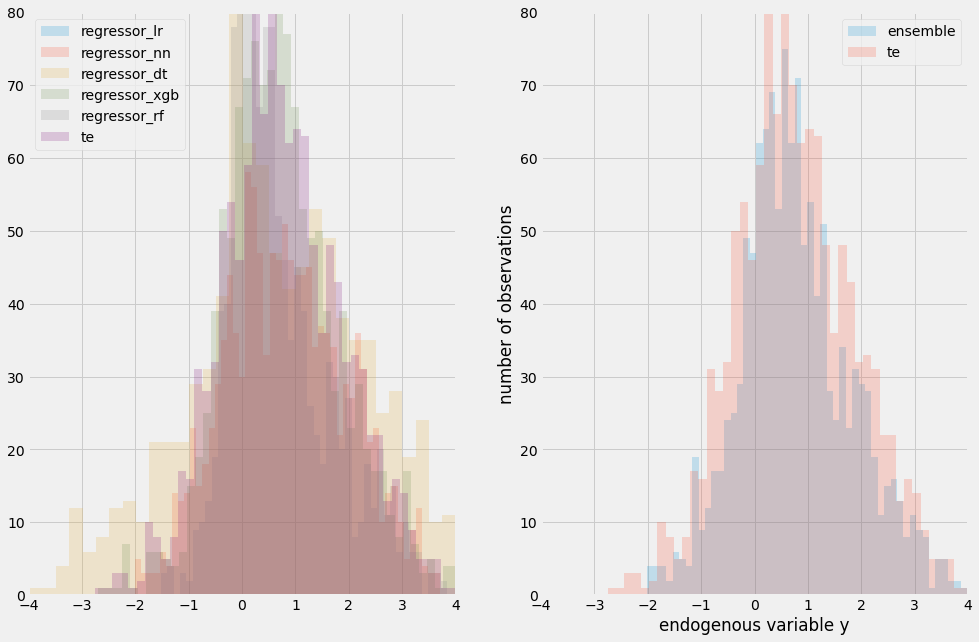

In [4]:
ensemble = SuperLearner(scorer=mean_squared_error, random_state=42)
ensemble.add([x for x in regressors.values()])
ensemble.add_meta(regressors['regressor_nn'])
e_preds_rand, tau_rand_test = simple_model.create_simple_ml_model(X_rand, y_rand, w_rand, tau_rand, ensemble)

plt.figure(figsize=(15, 10))
simple_model.multilayer_hist(rand_preds, tau_rand_test, 121)
simple_model.multilayer_hist({'ensemble':e_preds_rand}, tau_rand_test, 122)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
plt.show()

In [5]:
stacking_helpers.show_MSE_r_square(rand_preds, tau_rand_test, e_preds_rand)

,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
MSE,1.334781,0.065488,2.151115,0.242406,0.30259,0.076779


,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
R-Squared,-0.01071,0.950412,-0.628846,0.816448,0.770876,0.941862


## Difficult nuisance components and an easy treatment effect

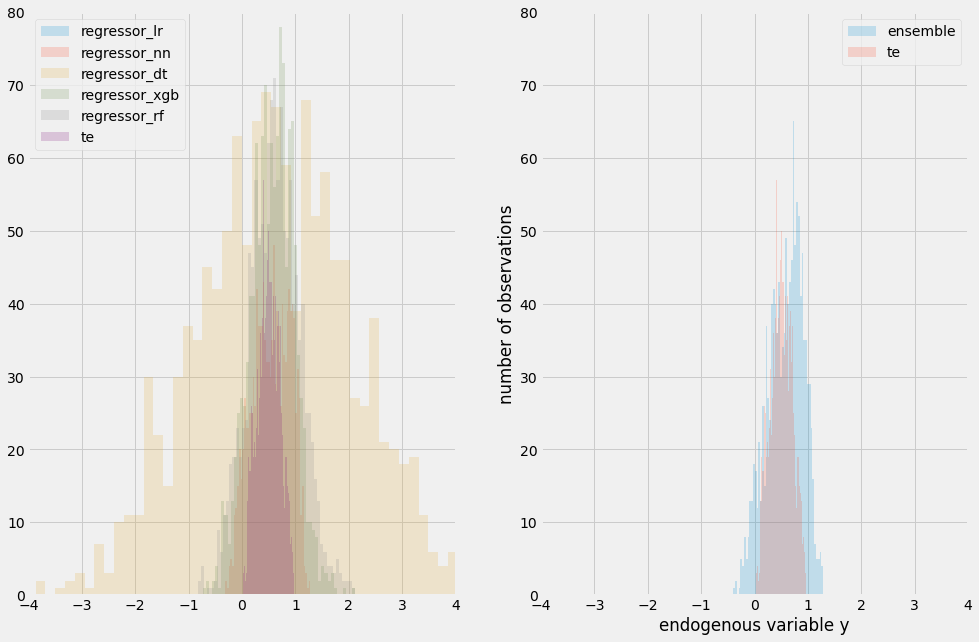

In [6]:
e_preds, tau_easy_test = simple_model.create_simple_ml_model(X_easy, y_easy, w_easy, tau_easy, ensemble)

plt.figure(figsize=(15, 10))
simple_model.multilayer_hist(easy_preds, tau_easy_test, 121)
simple_model.multilayer_hist({'ensemble':e_preds}, tau_easy_test, 122)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
plt.show()

In [7]:
stacking_helpers.show_MSE_r_square(easy_preds, tau_easy_test, e_preds)

,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
MSE,0.076244,0.034015,2.17994,0.116392,0.179329,0.044262


,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
R-Squared,-0.812903,0.191201,-50.833837,-1.767535,-3.264016,-0.052453


## Easy propensity and a difficult baseline
finaly try the difficult baseline below. how do the models do when the treatment effect is 1, while the nuisance variables are highly confounded and mode difficult to estimate than the propensity score?

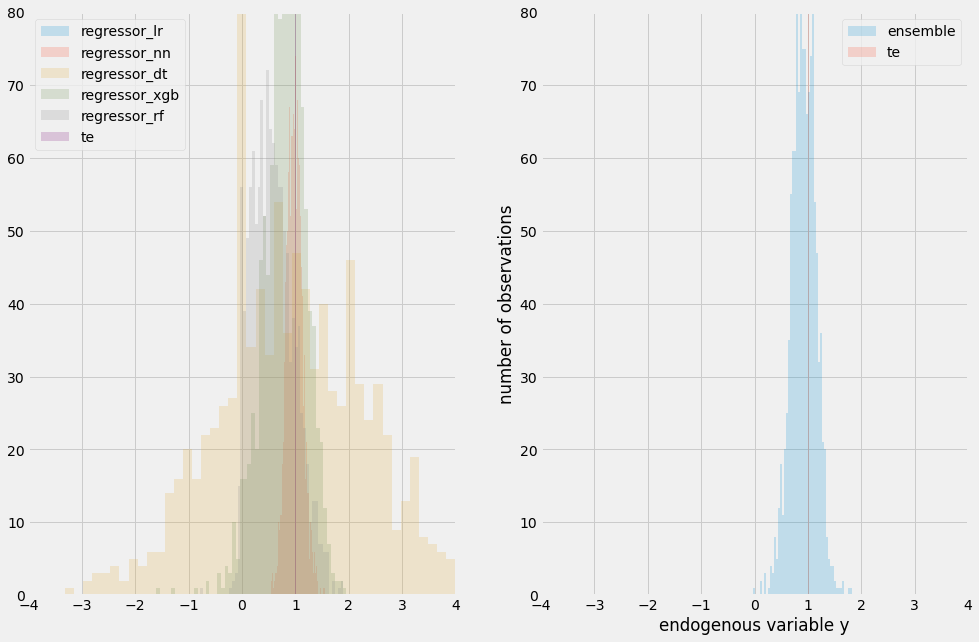

In [8]:
e_preds_difficult, tau_difficult_test = simple_model.create_simple_ml_model(X_difficult, y_difficult, w_difficult, tau_difficult, ensemble)

plt.figure(figsize=(15, 10))
simple_model.multilayer_hist(difficult_preds, tau_difficult_test, 121)
simple_model.multilayer_hist({'ensemble':e_preds_difficult}, tau_difficult_test, 122)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
plt.show()

In [9]:
stacking_helpers.show_MSE_r_square(difficult_preds, tau_difficult_test, e_preds_difficult)

,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
MSE,0.001818,0.021841,1.686773,0.19759,0.330747,0.058514


,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
R-Squared,0.0,0.0,0.0,0.0,0.0,0.0


so now that we have more or less a framework for the simple case of predicting treatment effects and obviously stacking does work ok
we can look at other ways to try stacking while incorporating double machine learning..

we can implement a psedo-stacking methodology on the R learner.
The difficulty in stacking with the libraries provided by the R learner

the pipeline for stacking can take many forms when esitmating treatment effects.

also need to mention when we talk about each of the datasets : what is the best possible outcome we can expect from any model? each dataset has its data generating function with more or less randomness introduced.


#A Different Proposal for Stacking to Estimate Treatment Effects

we can use this to stack estimates exactly as in Grimmer, and compare them to the R learners/DML learnings (also stacked) as in Nie, Wager
this would answer the questions:
 - how does stacking **without** double machine learning compare to the R learner on its own? Is there an advantage to using (the best..) R learner over simple stacking? and what kind of libraries are already available for such a pipeline?
 - how much can stacking help if we do not (can not) estimate propensity scores or distinct nuisance functions in the dataset?
 - how does stacking an R learner compare to (the best) single DML model?

the S learner does not explicitly account for propensity scores, or for the 'nuisance funciton' separate from the treatment effect.

the R learner, on the other hand:
 - R leaner, DML, etc etc.
 - The proposal from Nie and Wager for using some 'out of the box models and stacking the treatment effect estimations

The R learner can also be fed different models, and the results similarly stacked.

this is actually a sad shortcoming of the `causalml` library, that it is not possible to feed models directly into sklearn.ensemble models.
normally an ensemble class from sklear would take a dict (i think..) of models and a dataset, do the entire pipeline, and then output the model.

if we would like to imitate grimmer we would also need a solution to the problem that we currently dont have a way to constrain the ensemble coefficients such that they must sum to 1.

## randomized trial - R learner

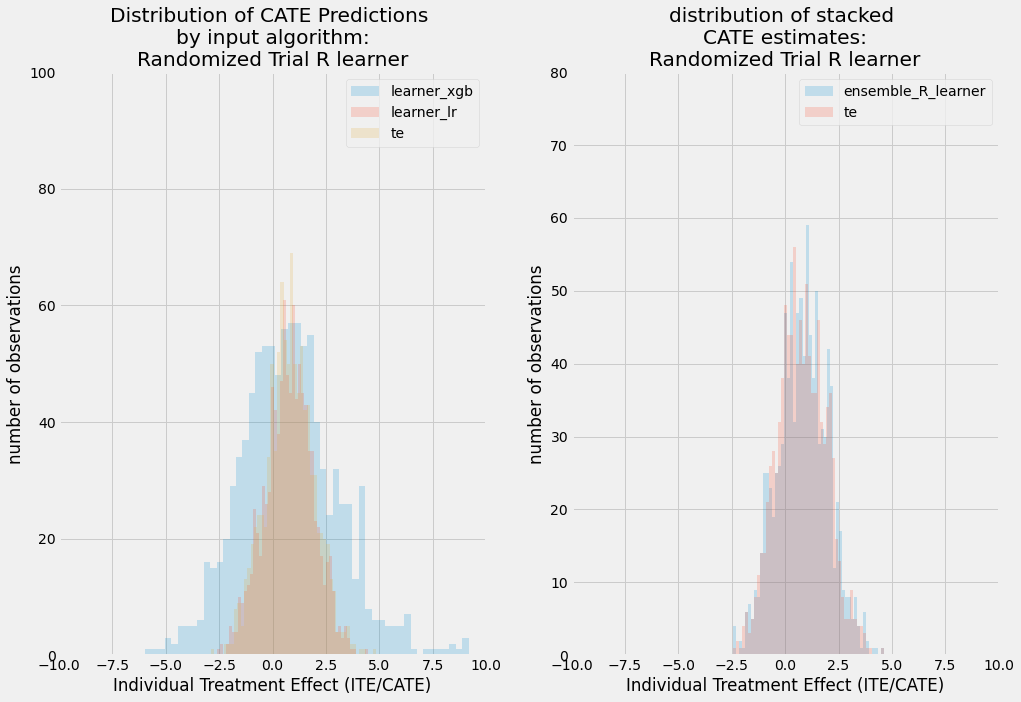

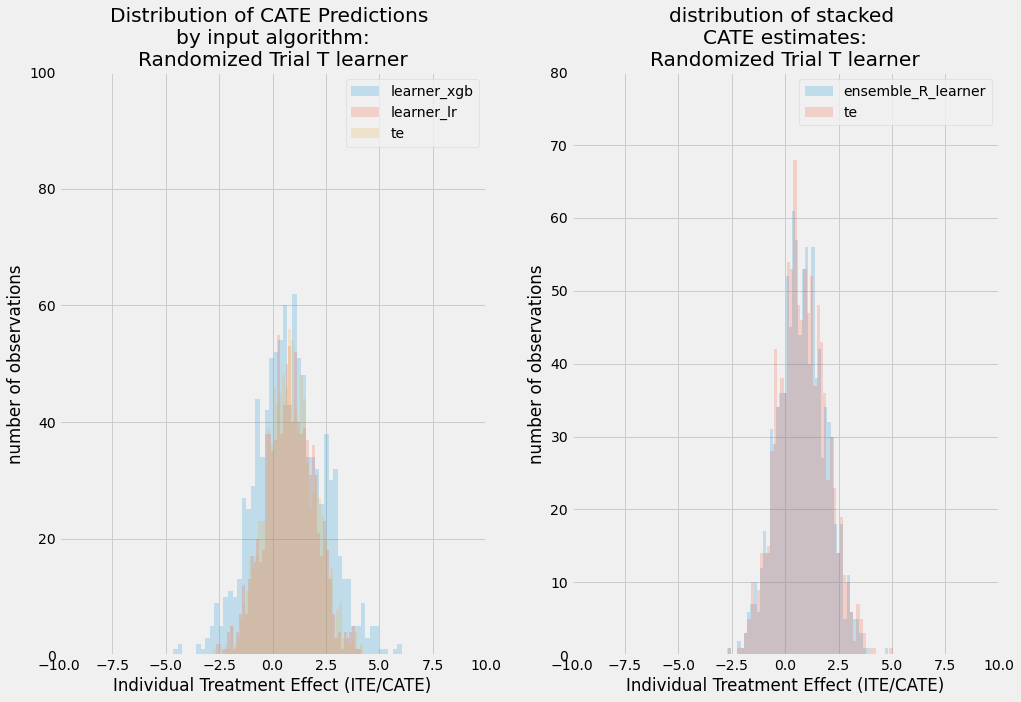

In [10]:
from data_gen import *

predictions_R = generate_predicitons_by_learner(estimators_R)
predictions_T = generate_predicitons_by_learner(estimators_T)

pred_R = predictions_R['predictions_randomized_trial']
pred_R_test = predictions_R['predictions_randomized_trial_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_R, pred_R_test, 'Randomized Trial R learner')
plt.show()

pred_T = predictions_T['predictions_randomized_trial']
pred_T_test = predictions_T['predictions_randomized_trial_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_T, pred_T_test, 'Randomized Trial T learner')
plt.show()

some commentary on what we are looking at above  etc. etc. etc.
## difficult baseline, easy treatment effect - R learner

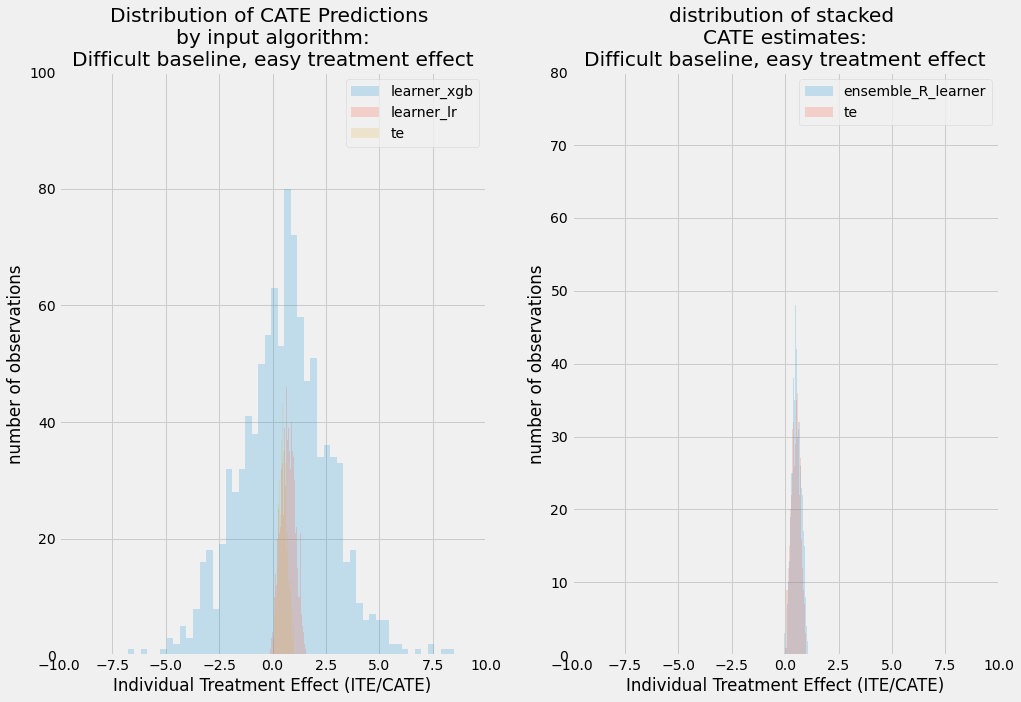

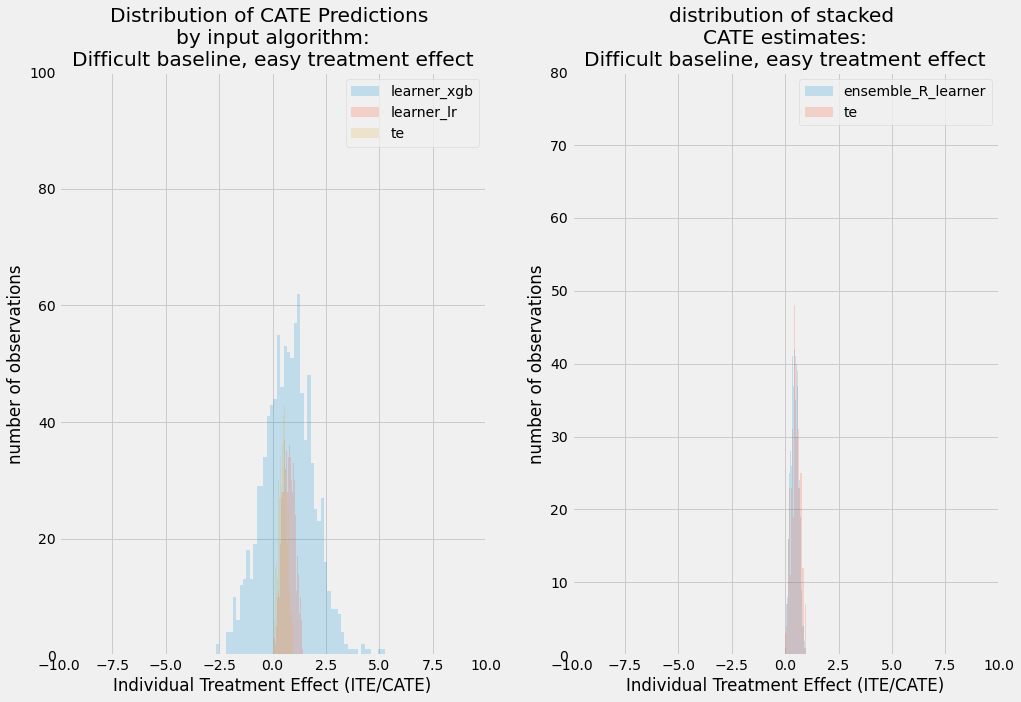

In [11]:
pred_R = predictions_R['predictions_easy_treatment']
pred_R_test = predictions_R['predictions_easy_treatment_test']


pred_T = predictions_T['predictions_easy_treatment']
pred_T_test = predictions_T['predictions_easy_treatment_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_R, pred_R_test, 'Difficult baseline, easy treatment effect')
plt.show()

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_T, pred_T_test, 'Difficult baseline, easy treatment effect')
plt.show()

again some commentary on what we are looking at above  etc. etc. etc. ...

## easy propensity difficult baseline - R learner

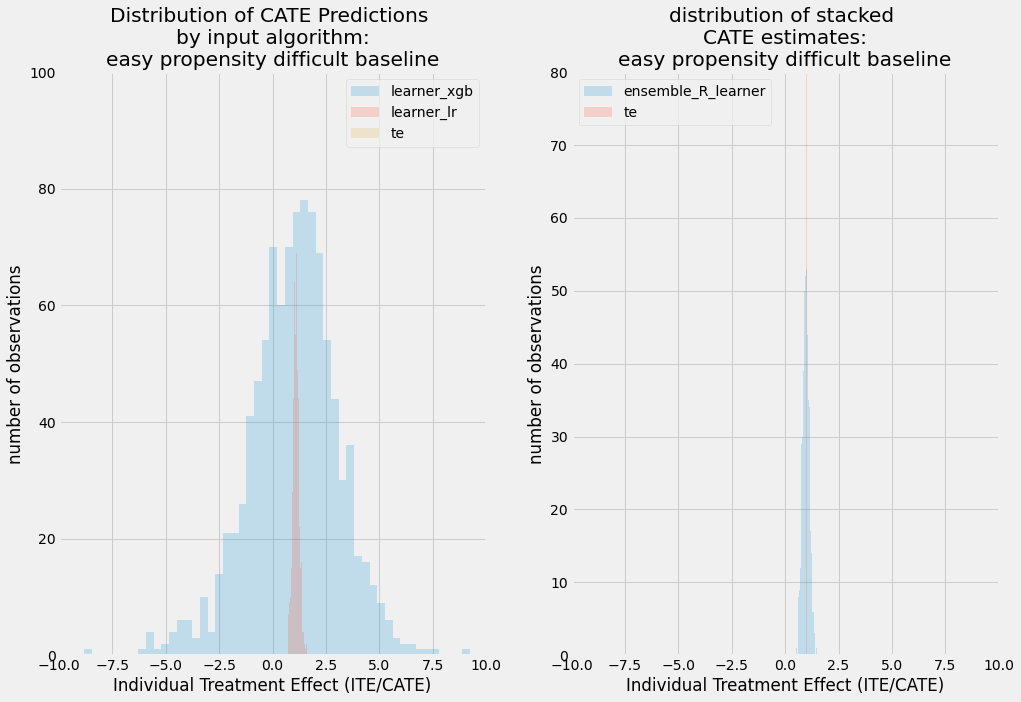

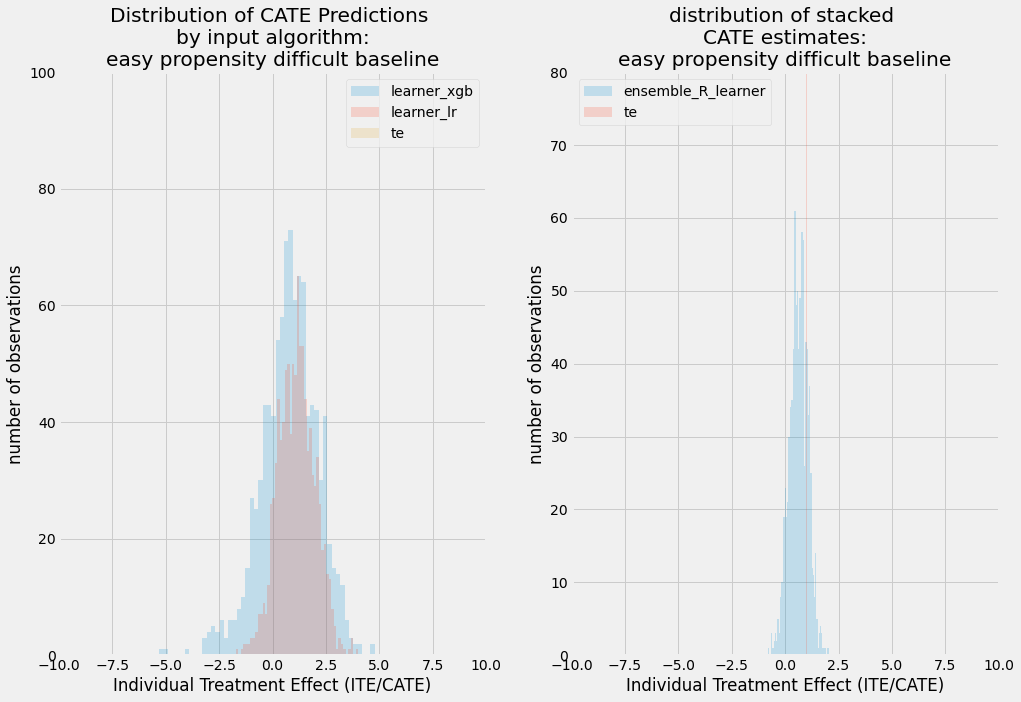

In [12]:
pred_R = predictions_R['predictions_easy_propensity']
pred_R_test = predictions_R['predictions_easy_propensity_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_R, pred_R_test, 'easy propensity difficult baseline')

plt.show()

pred_T = predictions_T['predictions_easy_propensity']
pred_T_test = predictions_T['predictions_easy_propensity_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_T, pred_T_test, 'easy propensity difficult baseline')

plt.show()

## still to do :

* figure out if all situations here are interesting, maybe just keep r learner for the dataset that the 'simple' version did the worst on.
* report MSE and R squared or something else to evaluate
* look at the OLS estimates, CI, SE for the 'stacking' models in the second part.
* write a readme
* probably do some renaming for the packages and functions in them.
* references